In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from google.colab import files
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set directories for the dataset
train_dir = '/content/drive/My Drive/Colab Notebooks/datasets/train/train'
test_dir = '/content/drive/My Drive/Colab Notebooks/datasets/test/test'

In [ ]:
# Define image parameters
IMAGE_SIZE = [224, 224]

In [ ]:
# Image Data Generator for training with augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SIZE,
                                               batch_size=32,
                                               class_mode='categorical')

Found 2187 images belonging to 7 classes.


In [ ]:
# Image Data Generator for testing/validation without augmentation
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SIZE,
                                             batch_size=32,
                                             class_mode='categorical')

Found 564 images belonging to 7 classes.


In [ ]:
# Load the VGG16 model with pre-trained ImageNet weights
vgg16_base = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze the pre-trained layers
for layer in vgg16_base.layers:
    layer.trainable = False

In [ ]:
# Add custom layers on top of VGG16
y = Flatten()(vgg16_base.output)
vgg16_prediction = Dense(train_data.num_classes, activation='softmax')(y)

In [ ]:
# Create the VGG16 model
model_vgg16 = Model(inputs=vgg16_base.input, outputs=vgg16_prediction)

In [ ]:
# Compile the model
model_vgg16.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Print VGG16 model summary
model_vgg16.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │         175,623 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 14,890,311 (56.80 MB)

 Trainable params: 175,623 (686.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Callbacks for VGG16
vgg16_checkpointer = ModelCheckpoint(filepath='vgg16_best_weights.keras', save_best_only=True, verbose=False)
vgg16_early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, mode='min')

In [ ]:
# Train the VGG16 model with corrected steps_per_epoch and validation_steps, without 'workers' and 'use_multiprocessing'
vgg16_history = model_vgg16.fit(train_data,
                                steps_per_epoch=train_data.samples // train_data.batch_size,  # Correct way to calculate steps per epoch
                                epochs=10,
                                callbacks=[vgg16_early_stop, vgg16_checkpointer],
                                validation_data=test_data,
                                validation_steps=test_data.samples // test_data.batch_size)  # Correct way to calculate validation steps

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 1630s 23s/step - accuracy: 0.3858 - loss: 1.8184 - val_accuracy: 0.5974 - val_loss: 1.0925
Epoch 2/10
 1/68 ━━━━━━━━━━━━━━━━━━━━ 19:23 17s/step - accuracy: 0.6875 - loss: 0.8027

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


68/68 ━━━━━━━━━━━━━━━━━━━━ 29s 180ms/step - accuracy: 0.6875 - loss: 0.8027 - val_accuracy: 0.6500 - val_loss: 0.8963
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1571s 22s/step - accuracy: 0.6080 - loss: 1.0800 - val_accuracy: 0.6507 - val_loss: 0.9772
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 29s 169ms/step - accuracy: 0.7188 - loss: 0.7110 - val_accuracy: 0.7000 - val_loss: 1.1148
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1511s 22s/step - accuracy: 0.6908 - loss: 0.8661 - val_accuracy: 0.6636 - val_loss: 0.9556
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 29s 176ms/step - accuracy: 0.6875 - loss: 0.6930 - val_accuracy: 0.6500 - val_loss: 0.8133
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1549s 22s/step - accuracy: 0.7140 - loss: 0.8199 - val_accuracy: 0.7151 - val_loss: 0.9261
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 28s 165ms/step - accuracy: 0.8125 - loss: 0.6108 - val_accuracy: 0.6000 - val_loss: 1.0529
Epoch 9/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1567s 22s/step - accuracy: 0.6935 - loss: 0.8604 - val_accuracy: 0.650

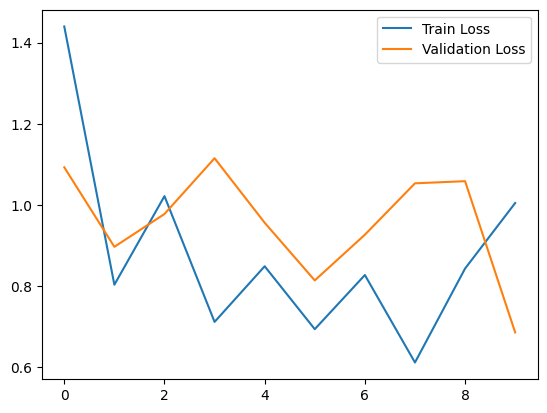

In [ ]:
# Plot training and validation loss
plt.plot(vgg16_history.history['loss'], label='Train Loss')
plt.plot(vgg16_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

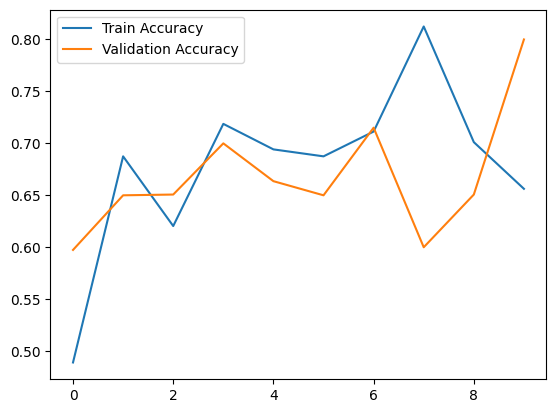

In [ ]:
# Plot training and validation accuracy
plt.plot(vgg16_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg16_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate VGG16 model on test data
vgg16_score = model_vgg16.evaluate(test_data)
print(f'VGG16 Test Loss: {vgg16_score[0]}')
print(f'VGG16 Test Accuracy: {vgg16_score[1]}')

18/18 ━━━━━━━━━━━━━━━━━━━━ 322s 17s/step - accuracy: 0.6777 - loss: 0.9564
VGG16 Test Loss: 0.9467509388923645
VGG16 Test Accuracy: 0.7021276354789734


In [ ]:
### Saving and Downloading the Model ###

In [ ]:
# 1. Save and Download VGG16 Model in .h5 Format
model_vgg16.save('vgg16_model.h5')
files.download('vgg16_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 2. Save and Download VGG16 Model in .keras Format
model_vgg16.save('vgg16_model.keras')
files.download('vgg16_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 3. Save and Download VGG16 Model Weights in .pkl Format Using pickle
vgg16_weights = model_vgg16.get_weights()

with open('vgg16_weights.pkl', 'wb') as f:
    pickle.dump(vgg16_weights, f)

files.download('vgg16_weights.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Testing

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf

In [ ]:
# Load the saved model (update path to your model file)
model = tf.keras.models.load_model('/content/vgg16_model.h5', compile=False)

In [ ]:
# Load and preprocess the image (update path to your image file)
img = image.load_img('/content/drive/MyDrive/Colab Notebooks/datasets/test/test/cardboard/cardboard108.jpg', target_size=(224, 224))  # Ensure target size matches your model input
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Normalize the image as done during training

In [ ]:
# Predict the class of the image
pred = model.predict(x)
pred_class = np.argmax(pred, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step


In [ ]:
# Class labels (update based on your training classes)
index = ['cardboard','compost', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
# Get the predicted class
result = str(index[pred_class[0]])
print(f'Predicted Class: {result}')

Predicted Class: cardboard


In [ ]:
# Loading keras file to Predict

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import os

In [ ]:
# Load the VGG16 model
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/vgg16 new/vgg16_model (1).keras', compile=False)

In [ ]:
def predict_image_class(image_path):
    """Predicts the class of an image from a file path using VGG16."""
    if not os.path.exists(image_path):
        print(f"Error: Image file not found at {image_path}")
        return None

    # Load, preprocess, and predict
    img = image.load_img(image_path, target_size=(224, 224))
    x = np.expand_dims(image.img_to_array(img), axis=0)
    x = tf.keras.applications.vgg16.preprocess_input(x)  # Preprocess for VGG16
    pred = model.predict(x)
    pred_class = np.argmax(pred, axis=1)

    # Define your class labels
    classes = ['cardboard','compost', 'glass', 'metal', 'paper', 'plastic', 'trash']
    return classes[pred_class[0]]

In [ ]:
# Example usage
image_path = "/content/drive/MyDrive/Colab Notebooks/datasets/test/test/metal/metal103.jpg"
predicted_class = predict_image_class(image_path)

if predicted_class:
    print(f"Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: metal
